# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

This is ostensibly the same code as the file in the _hjpdes_experiments_1D folder, except that we use here
the LPN module directly. This is because the experiments in _hjpdes_experiments_1D rely on the utils.py and network.py
files which assume the input is one-dimensional.

## Import modules 

In [27]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": True})
sns.set_theme()

# Utility functions and plotting tools

In [28]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [29]:
# Dimension
dim = 2

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 50

# Number of samples from the solution we have access to
data_points = 500

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [30]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# Example: Visualize the target convex and prior functions in 2D

Text(0, 0.5, 'prior_true($x_2$,0)')

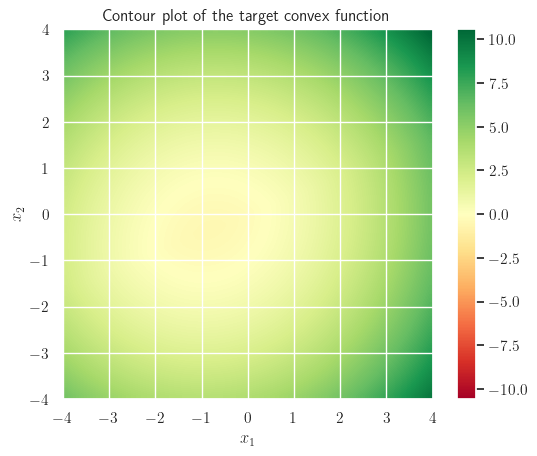

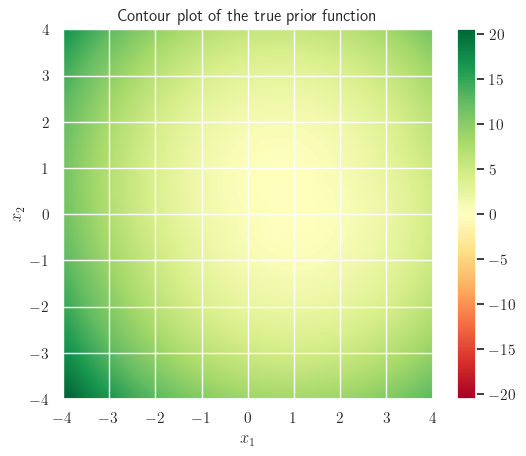

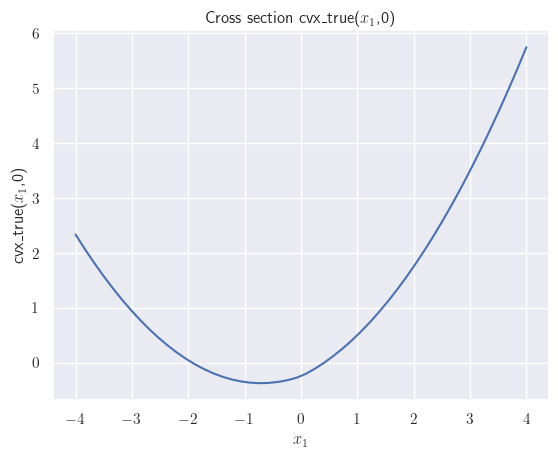

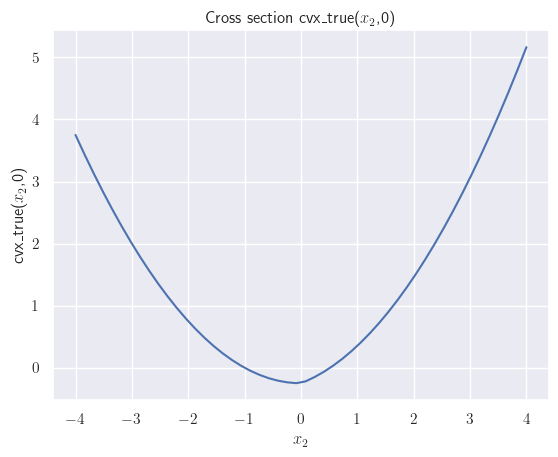

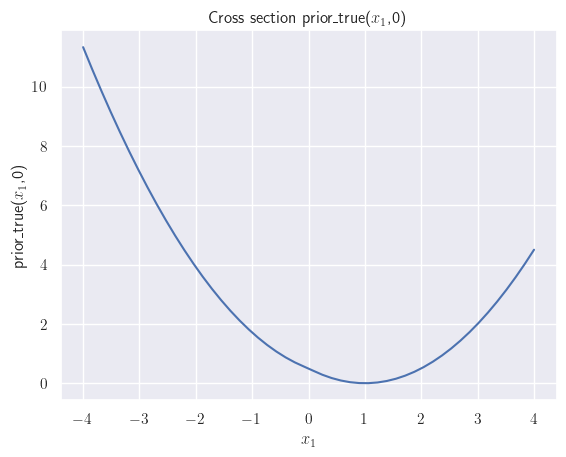

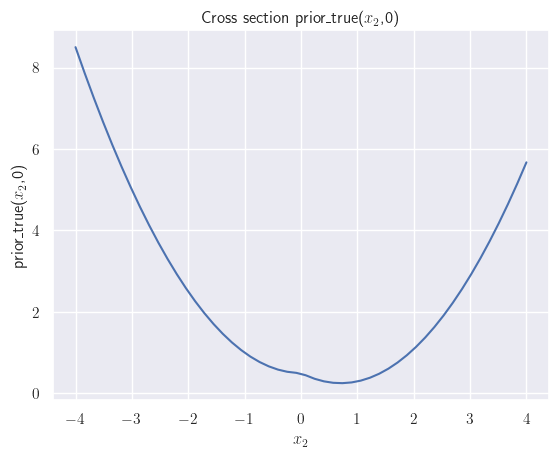

In [31]:
# Generate a square [-a, a]^{2} square meshgrid and recover the list of points
xi = np.linspace(-a,a,spacing)
mesh = np.meshgrid(xi, xi) 

# Recover the list of points as a matrix with 2 columns
pts = np.array(mesh).reshape(2, -1).T

# Evaluate the target convex and prior functions, then reshape them to fit the meshgrid
example_cvx_true = cvx_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
example_prior_true = prior_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

# Plot 2D contours cvx_true(x1,x2) = C
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(example_cvx_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_cvx_true).max(), vmin=-abs(example_cvx_true).max())

plt.title('Contour plot of the target convex function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# Plot 2D contours prior_true(x1,x2) = C
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(example_prior_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_prior_true).max(), vmin=-abs(example_prior_true).max())

plt.title('Contour plot of the true prior function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)

# Plot the cross sections cvx_true(x1,0), cvx_true(0,x2), prior_true(x1,0) and prior_true(0,x2)
x1_0_points = np.array(np.meshgrid(xi, 0) ).reshape(2, -1).T
x2_0_points = np.array(np.meshgrid(0, xi) ).reshape(2, -1).T

x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

plt.subplots()
plt.plot(xi, x1_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('cvx_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('cvx_true($x_2$,0)')

plt.subplots()
plt.plot(xi, x1_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('prior_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('prior_true($x_2$,0)')

## Training function

In [32]:
def single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [33]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 9.283333778381348
iteration 0 loss 124.92646789550781
iteration 500 loss 1.9553942680358887
iteration 1000 loss 0.7213718295097351
iteration 1500 loss 0.6186626553535461
iteration 2000 loss 0.5631558895111084
iteration 2500 loss 0.4938430190086365
iteration 3000 loss 0.408199667930603
iteration 3500 loss 0.3103567361831665
iteration 4000 loss 0.2118697613477707
iteration 4500 loss 0.12391261756420135
iteration 5000 loss 0.06354048103094101
iteration 5500 loss 0.031282659620046616
iteration 6000 loss 0.017630213871598244
iteration 6500 loss 0.011272004805505276
iteration 7000 loss 0.007527426350861788
iteration 7500 loss 0.0053502232767641544
iteration 8000 loss 0.00398839870467782
iteration 8500 loss 0.0030033811926841736
iteration 9000 loss 0.002286582952365279
iteration 9500 loss 0.0017328644171357155
iteration 10000 loss 0.0013099800562486053
iteration 10500 loss 0.0009837975958362222
iteration 11000 loss 0.0007311736117117107
iteration 11500 loss 0.0005406645359471

L2 loss -- Plot

loss -11.255913734436035
loss -59.00060272216797
loss -98.26373291015625
loss -131.19923400878906
loss -159.38186645507812
loss -183.6378173828125
loss -204.11111450195312
loss -221.08570861816406
loss -235.29293823242188
loss -247.15049743652344
loss -256.61248779296875
loss -264.1691589355469
loss -270.5224609375
loss -276.2108459472656
loss -281.6558532714844
loss -287.0783996582031
loss -292.5765686035156
loss -298.18798828125
loss -303.90802001953125
loss -309.7154541015625
loss -315.58612060546875
loss -321.4975891113281
loss -327.43255615234375
loss -333.37847900390625
loss -339.326416015625
loss -345.27001953125
loss -351.2048034667969
loss -357.1281433105469
loss -363.0379943847656
loss -368.9345703125
loss -374.8189392089844
loss -380.6921691894531
loss -386.5554504394531
loss -392.40948486328125
loss -398.25445556640625
loss -404.0889587402344
loss -409.9118957519531
loss -415.72430419921875
loss -421.52728271484375
loss -427.3201904296875
final mse:  0.1200300008058548
max,

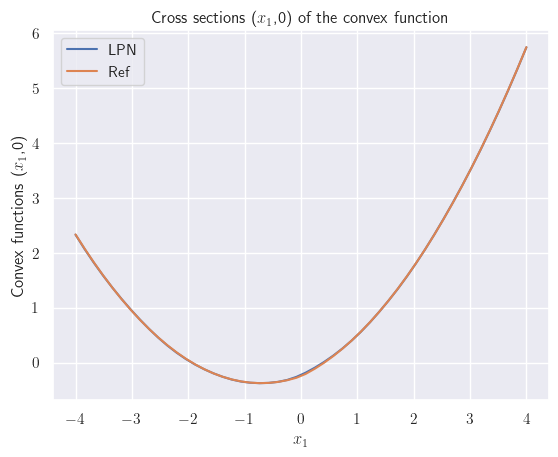

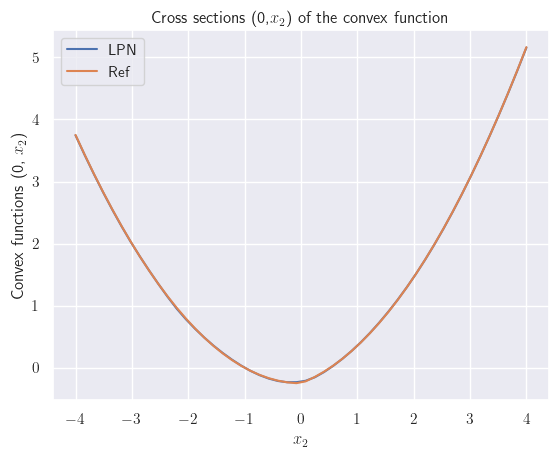

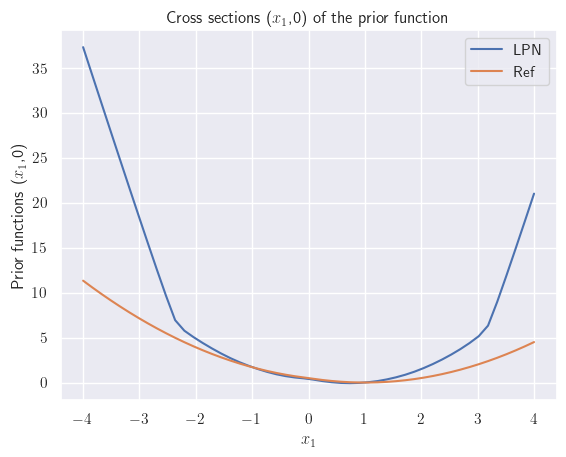

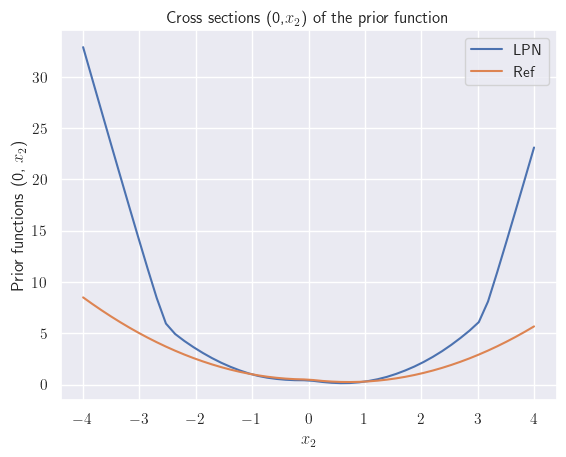

In [34]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

L1 loss -- Train

In [43]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

iteration 0 loss 3.460376501083374
iteration 0 loss 9.559946060180664
iteration 500 loss 0.6499095559120178
iteration 1000 loss 0.46246418356895447
iteration 1500 loss 0.2695845365524292
iteration 2000 loss 0.14645887911319733
iteration 2500 loss 0.06512866169214249
iteration 3000 loss 0.02440181002020836
iteration 3500 loss 0.01634109765291214
iteration 4000 loss 0.013313242234289646
iteration 4500 loss 0.012133934535086155
iteration 5000 loss 0.010071036405861378
iteration 5500 loss 0.009343299083411694
iteration 6000 loss 0.009952740743756294
iteration 6500 loss 0.007421897724270821
iteration 7000 loss 0.009507027454674244
iteration 7500 loss 0.006699234712868929
iteration 8000 loss 0.007779737003147602
iteration 8500 loss 0.005854723509401083
iteration 9000 loss 0.008045189082622528
iteration 9500 loss 0.006833310704678297
iteration 10000 loss 0.006287700962275267
iteration 10500 loss 0.0069120884872972965
iteration 11000 loss 0.0045760516077280045
iteration 11500 loss 0.0059092883

L1 loss -- Plot

loss -10.77962589263916
loss -58.48621368408203
loss -98.12547302246094
loss -131.60055541992188
loss -160.28187561035156
loss -183.8995819091797
loss -203.9427490234375
loss -220.891357421875
loss -235.1369171142578
loss -247.04248046875
loss -256.9140930175781
loss -264.9967041015625
loss -272.1780700683594
loss -279.0340270996094
loss -285.8287353515625
loss -292.6916198730469
loss -299.67584228515625
loss -306.78643798828125
loss -314.00408935546875
loss -321.3018798828125
loss -328.6544189453125
loss -336.0418701171875
loss -343.4497985839844
loss -350.868408203125
loss -358.2909240722656
loss -365.71331787109375
loss -373.13250732421875
loss -380.54718017578125
loss -387.9562072753906
loss -395.3597412109375
loss -402.7569885253906
loss -410.1476135253906
loss -417.531982421875
loss -424.91058349609375
loss -432.2842102050781
loss -439.65570068359375
loss -447.0237731933594
loss -454.38909912109375
loss -461.7522888183594
loss -469.1137390136719
final mse:  0.17149396240711212
ma

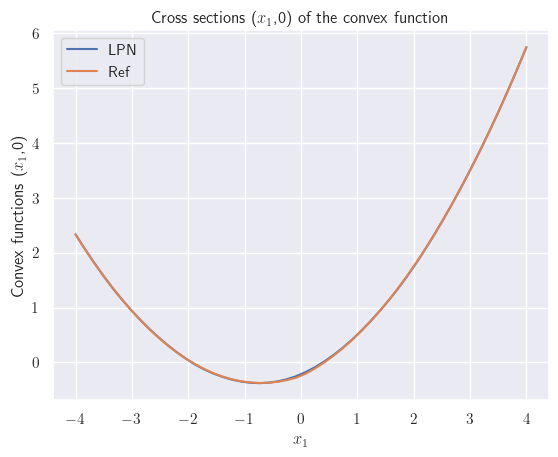

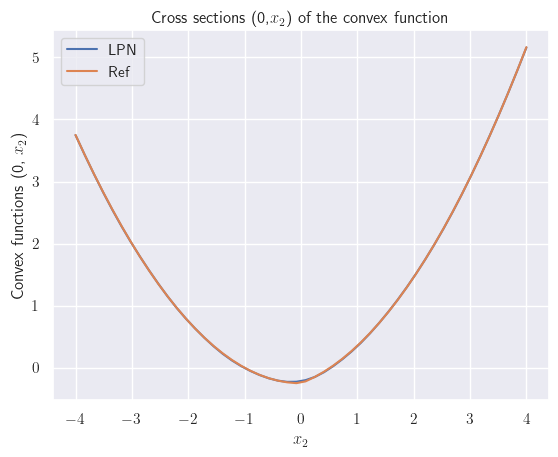

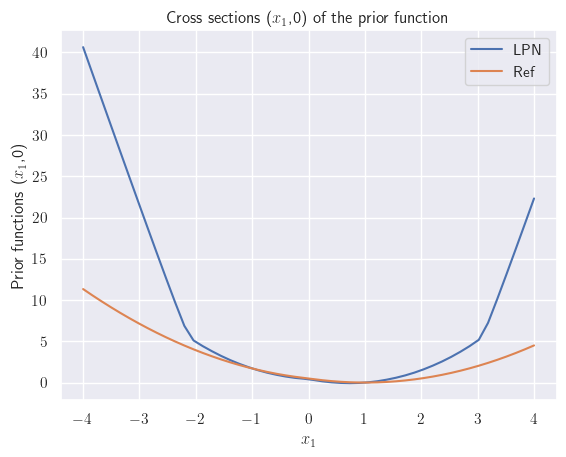

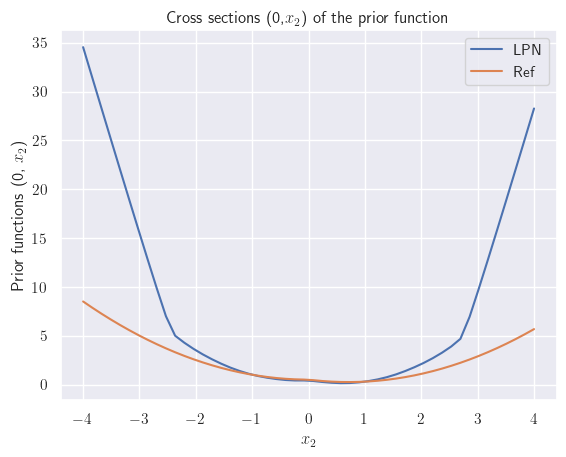

In [44]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [37]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [38]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [39]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [40]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [41]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [42]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)